[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available.

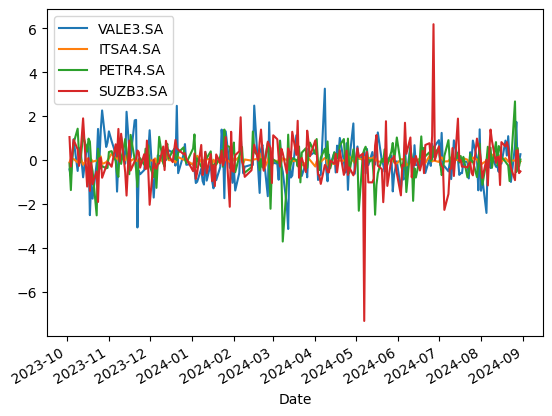

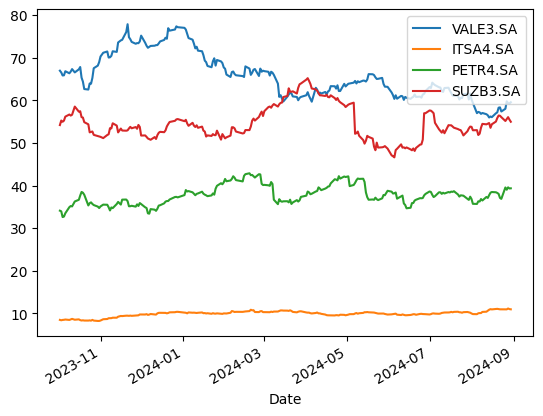

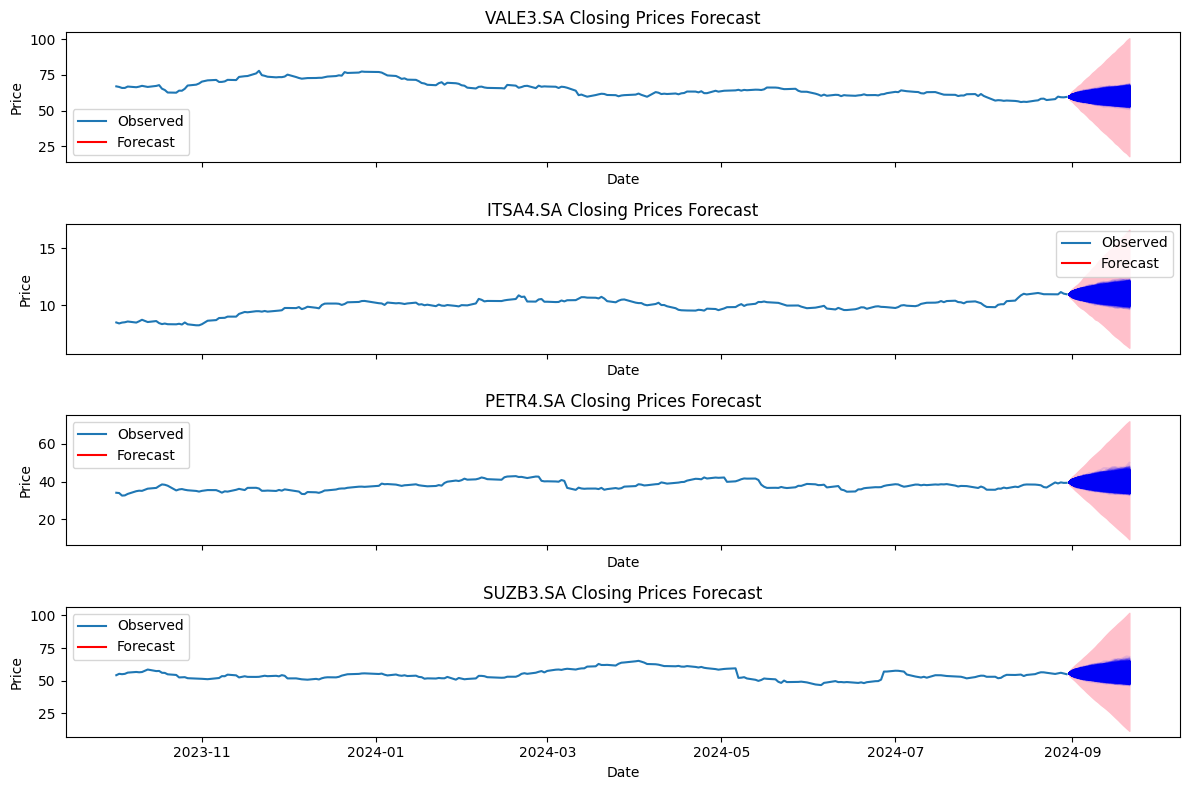

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm  
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import os

to_date = (datetime.datetime.now() - datetime.timedelta(days=0)).strftime('%Y-%m-%d')
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA", "SUZB3.SA"]
data = {ticker: yf.download(ticker, start="2023-10-01", end=to_date) for ticker in tickers}


close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
close_prices_diff = close_prices.diff().dropna()
close_prices_diff.plot()
close_prices.plot()

# SARIMAX
def fit_sarimax(ticker, close_prices_diff, close_prices, steps=22):
    model = sm.tsa.statespace.SARIMAX(close_prices_diff[ticker], 
                                      order=(1,1,1), 
                                      seasonal_order=(1,1,1,12), 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    pred_diff = results.get_forecast(steps=steps)
    pred_diff_ci = pred_diff.conf_int()
    
    # Converte a diff em forecast real
    last_actual = close_prices[ticker].iloc[-1]
    pred = last_actual + pred_diff.predicted_mean.cumsum()
    
    pred_ci = pred_diff_ci.cumsum() + last_actual
# Date Range pro forecast
    last_date = close_prices.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps)
    
    return pred, pred_ci, pred_dates


def simulate_gbm(start_price, mu, sigma, days, n_simulations=100000, volatility_factor=3):
    sigma *= volatility_factor  # Mexe na volatilidade
    dt = 1 / days
    prices = np.zeros((days, n_simulations))
    prices[0] = start_price
    for t in range(1, days):
        random_shocks = np.random.normal(mu * dt, sigma * np.sqrt(dt), n_simulations)
        prices[t] = prices[t-1] * np.exp(random_shocks)
    return prices

# criando função de tabela de probabilidade
def create_probability_table(gbm_simulations, pred_dates):
    rounded_simulations = np.round(gbm_simulations, 2)  # Round to two decimal places
    prob_table = pd.DataFrame(index=pred_dates)
    
    for day in range(rounded_simulations.shape[0]):
        value_counts = pd.Series(rounded_simulations[day]).value_counts(normalize=True)
        value_counts.name = pred_dates[day]
        prob_table = prob_table.join(value_counts, how='outer')
    
    prob_table = prob_table.fillna(0)
    prob_table.index.name = 'Value'
    return prob_table

fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 8), sharex=True)

# Create output directories if they don't exist
output_dir = "Saídas_modelos"
simulation_dir = os.path.join(output_dir, "Simulation")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(simulation_dir, exist_ok=True)

for i, ticker in enumerate(tickers):
    pred, pred_ci, pred_dates = fit_sarimax(ticker, close_prices_diff, close_prices)
    
    axes[i].plot(close_prices[ticker], label='Observed')
    axes[i].plot(pred_dates, pred, label='Forecast', color='red')
    axes[i].fill_between(pred_dates, 
                         pred_ci.iloc[:, 0], 
                         pred_ci.iloc[:, 1], color='pink')
    axes[i].set_title(f"{ticker} Closing Prices Forecast")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].legend()
    
    pred_df = pd.DataFrame({
        'Date': pred_dates,
        'Prediction': pred,
        'Lower_CI': pred_ci.iloc[:, 0],
        'Upper_CI': pred_ci.iloc[:, 1]
    }).set_index('Date')
    
    combined_df = pd.concat([close_prices[ticker], pred_df], axis=1)
    combined_df.columns = ['Actual', 'Prediction', 'Lower_CI', 'Upper_CI']
    
    combined_df.to_csv(os.path.join(output_dir, f"{ticker}_predictions.csv"))

    mu = 0  
    sigma = close_prices[ticker].pct_change().std()
    gbm_simulations = simulate_gbm(pred.iloc[0], mu, sigma, len(pred_dates), volatility_factor=2.5)
    
    sim_df = pd.DataFrame(gbm_simulations, index=pred_dates)
    sim_df.to_csv(os.path.join(simulation_dir, f"{ticker}_simulations.csv"))

    prob_table = create_probability_table(gbm_simulations, pred_dates)
    prob_table.to_csv(os.path.join(simulation_dir, f"{ticker}_probability_table.csv"))

    for sim in gbm_simulations.T:
        axes[i].plot(pred_dates, sim, color='blue', alpha=0.1)

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available.

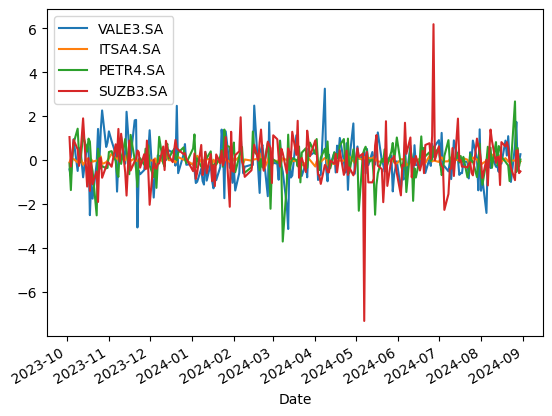

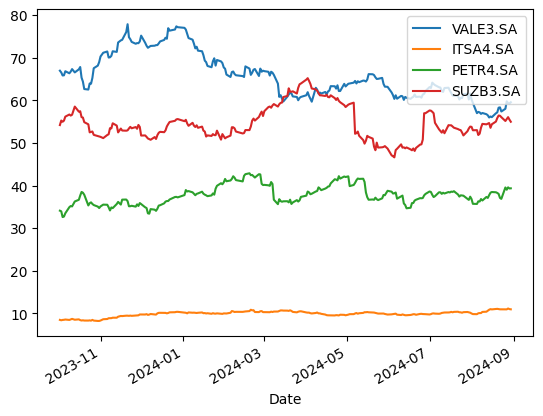

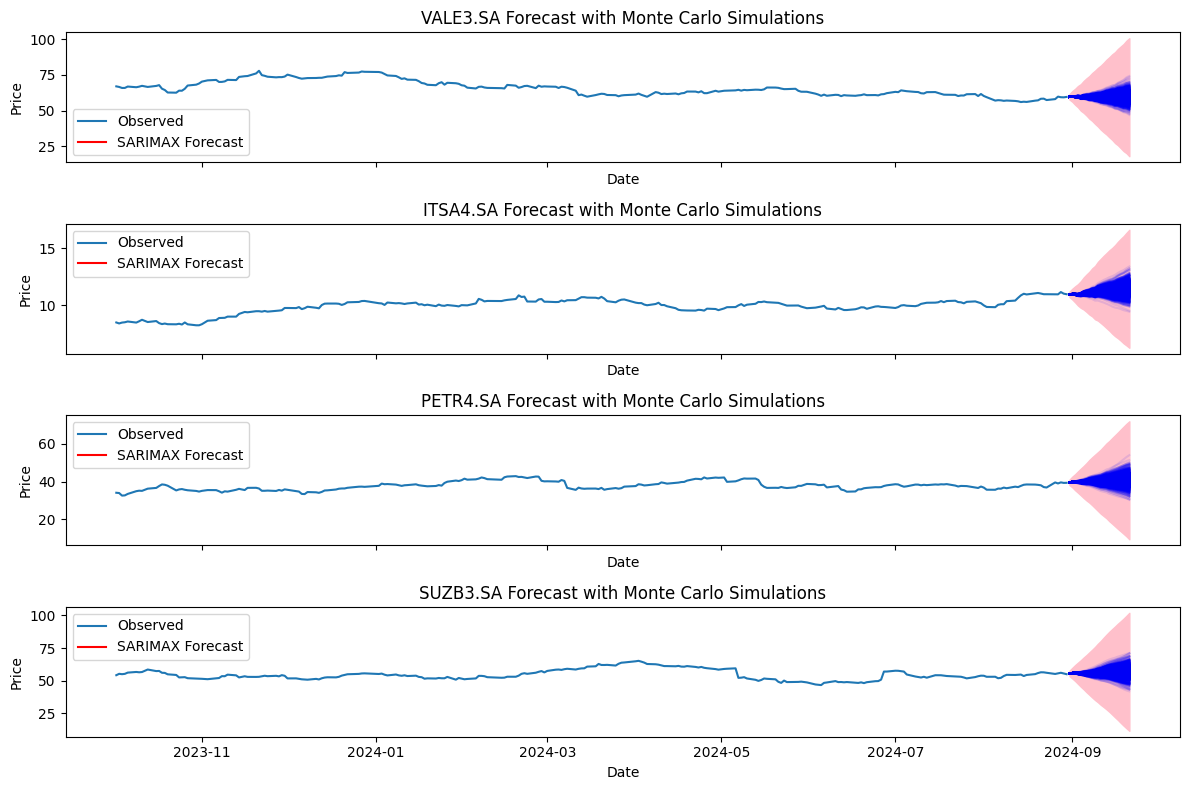

                  0          1          2          3          4          5    \
2024-08-31  55.588823  55.588823  55.588823  55.588823  55.588823  55.588823   
2024-09-01  55.822385  55.791469  55.763893  55.774615  55.811106  55.896994   
2024-09-02  55.804993  55.848930  55.712155  55.881593  55.911614  56.176376   
2024-09-03  55.540488  55.719647  55.418612  55.690767  55.660439  56.248459   
2024-09-04  55.223491  55.617277  55.185091  55.595769  55.386453  56.312546   

                  6          7          8          9    ...        990  \
2024-08-31  55.588823  55.588823  55.588823  55.588823  ...  55.588823   
2024-09-01  55.849212  55.993200  55.854777  55.696824  ...  55.925019   
2024-09-02  55.956213  56.296606  56.018917  55.716757  ...  56.216498   
2024-09-03  55.822342  56.347433  56.031851  55.484012  ...  56.284828   
2024-09-04  55.624440  56.413974  55.970446  55.182878  ...  56.370004   

                  991        992        993        994        995        9

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

# Setting the date range
to_date = (datetime.datetime.now() - datetime.timedelta(days=0)).strftime('%Y-%m-%d')
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA", "SUZB3.SA"]
data = {ticker: yf.download(ticker, start="2023-10-01", end=to_date) for ticker in tickers}

# Preparing the data
close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
close_prices_diff = close_prices.diff().dropna()

# Plotting the data
close_prices_diff.plot()
close_prices.plot()

# SARIMAX fitting function
def fit_sarimax(ticker, close_prices_diff, close_prices, steps=22):
    model = sm.tsa.statespace.SARIMAX(close_prices_diff[ticker], 
                                      order=(1,1,1), 
                                      seasonal_order=(1,1,1,12), 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    pred_diff = results.get_forecast(steps=steps)
    pred_diff_ci = pred_diff.conf_int()
    
    # Convert diff forecast back to actual forecast
    last_actual = close_prices[ticker].iloc[-1]
    pred = last_actual + pred_diff.predicted_mean.cumsum()
    
    pred_ci = pred_diff_ci.cumsum() + last_actual
    
    # Date range for the forecast
    last_date = close_prices.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps)
    
    return pred, pred_ci, pred_dates

# Monte Carlo simulation based on the last actual price
def monte_carlo_simulation(start_price, sigma, days, n_simulations=1000, volatility_factor=0.4):
    adjusted_sigma = sigma * volatility_factor  # Adjusting the volatility
    dt = 1 / days
    prices = np.zeros((days, n_simulations))
    prices[0] = start_price
    for t in range(1, days):
        random_shocks = np.random.normal(0, adjusted_sigma * np.sqrt(dt), n_simulations)
        prices[t] = prices[t-1] * np.exp(random_shocks)
    return prices

# Plot setup
fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 8), sharex=True)

# Create output directories if they don't exist
output_dir = "Saídas_modelos"
simulation_dir = os.path.join(output_dir, "Simulation")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(simulation_dir, exist_ok=True)

# Process each ticker
for i, ticker in enumerate(tickers):
    # Step 1: Fit SARIMAX and get predictions
    pred, pred_ci, pred_dates = fit_sarimax(ticker, close_prices_diff, close_prices)
    
    # Plot the SARIMAX prediction
    axes[i].plot(close_prices[ticker], label='Observed')
    axes[i].plot(pred_dates, pred, label='SARIMAX Forecast', color='red')
    axes[i].fill_between(pred_dates, 
                         pred_ci.iloc[:, 0], 
                         pred_ci.iloc[:, 1], color='pink')
    
    axes[i].set_title(f"{ticker} Forecast with Monte Carlo Simulations")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].legend()
    
    # Step 2: Perform Monte Carlo simulation
    last_actual_price = close_prices[ticker].iloc[-1]
    sigma = close_prices[ticker].pct_change().std()
    steps = len(pred_dates)  # Number of days to simulate
    monte_carlo_simulations = monte_carlo_simulation(last_actual_price, sigma, steps, n_simulations=1000, volatility_factor=0.4)
    
    # Step 3: Calculate cumulative sum of differences
    diff_df = pd.DataFrame(monte_carlo_simulations - last_actual_price, index=pred_dates)
    cum_diff_df = diff_df.cumsum()
    
    # Step 4: Add cumulative differences to SARIMAX predictions
    # Broadcasting the addition to match shapes
    final_simulations = cum_diff_df.add(pred.values[:, np.newaxis], axis=0)
    
    # Save the simulation results
    final_simulations.to_csv(os.path.join(simulation_dir, f"{ticker}_final_simulations.csv"))
    
    # Plot the final simulations
    for col in final_simulations.columns:
        axes[i].plot(pred_dates, final_simulations[col], color='blue', alpha=0.1)  # Plotting each Monte Carlo path

plt.tight_layout()
plt.show()

# Display the final simulation DataFrame for one of the tickers
print(final_simulations.head())




#### Fix Probabilities

In [22]:
import os
import pandas as pd
from datetime import datetime

folder_path = './Saídas_modelos/Simulation'

# Function to check if a string is a date
def is_date(string, date_format='%Y-%m-%d %H:%M:%S'):
    try:
        datetime.strptime(string, date_format)
        return True
    except ValueError:
        return False


for file_name in os.listdir(folder_path):
    if file_name.endswith('_probability_table.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Remove rows where the 'Value' column is a date
        df = df[~df['Value'].apply(is_date)]
        
        # Cara essa merda tava em string
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        
        # Sort the DataFrame by the 'Value' column in ascending order
        df = df.sort_values(by='Value', ascending=True)
        
        # Save the cleaned DataFrame back to the CSV file
        df.to_csv(file_path, index=False)

# Second Pass: Compute cumulative sums and save as Excel with percentages
for file_name in os.listdir(folder_path):
    if file_name.endswith('_probability_table.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the cleaned CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Ensure the 'Value' column is numeric for proper sorting
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        
        # Sort the DataFrame by the 'Value' column in ascending order
        df = df.sort_values(by='Value', ascending=True)
        df_cumsum = df.copy()
        for column in df.columns:
            if column != 'Value':
                df_cumsum[column] = df[column].cumsum().apply(lambda x: f"{x * 100:.4f}%")
        
        
        excel_file_path = os.path.join(folder_path, f"{file_name.replace('.csv', '.xlsx')}")
        df_cumsum.to_excel(excel_file_path, index=False)

print('All CSV files have been processed and saved as Excel files successfully.')

TypeError: strptime() argument 1 must be str, not float

#### Para o Monte Carlo Tem que ajeitar as probabilidades denovo Versão atualizada

In [3]:
import os
import pandas as pd
from datetime import datetime

folder_path = './Saídas_modelos/Simulation'

# Function to check if a string is a date
def is_date(string, date_format='%Y-%m-%d %H:%M:%S'):
    try:
        datetime.strptime(string, date_format)
        return True
    except ValueError:
        return False

# Function to create a probability table for each value in the simulations
def create_probability_table(df):
    probability_table = pd.DataFrame(index=df.index)

    for date in df.index:
        date_simulations = df.loc[date]
        value_counts = date_simulations.value_counts(normalize=True).sort_index()
        probability_table = probability_table.join(value_counts, how='outer', rsuffix=f'_{date}')

    probability_table.fillna(0, inplace=True)
    return probability_table

# Step 1: Create Probability Tables for each simulation result
for file_name in os.listdir(folder_path):
    if file_name.endswith('_final_simulations.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        prob_table = create_probability_table(df)
        prob_table.reset_index(inplace=True)
        prob_table.rename(columns={'index': 'Value'}, inplace=True)

        # Save the probability table as a CSV file
        prob_table_file_path = os.path.join(folder_path, f"{file_name.replace('.csv', '_probability_table.csv')}")
        prob_table.to_csv(prob_table_file_path, index=False)

# Step 2: Process the Probability Tables
for file_name in os.listdir(folder_path):
    if file_name.endswith('_probability_table.csv'):
        file_path = os.path.join(folder_path, file_name)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Remove rows where the 'Value' column is a date
        df = df[~df['Value'].apply(is_date)]

        # Ensure the 'Value' column is numeric for proper sorting
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

        # Sort the DataFrame by the 'Value' column in ascending order
        df = df.sort_values(by='Value', ascending=True)

        # Save the cleaned DataFrame back to the CSV file
        df.to_csv(file_path, index=False)

# Step 3: Compute cumulative sums and save as Excel with percentages
for file_name in os.listdir(folder_path):
    if file_name.endswith('_probability_table.csv'):
        file_path = os.path.join(folder_path, file_name)

        # Read the cleaned CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Ensure the 'Value' column is numeric for proper sorting
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

        # Sort the DataFrame by the 'Value' column in ascending order
        df = df.sort_values(by='Value', ascending=True)
        df_cumsum = df.copy()

        for column in df.columns:
            if column != 'Value':
                df_cumsum[column] = df[column].cumsum().apply(lambda x: f"{x * 100:.4f}%")

        # Save the cumulative sum DataFrame as an Excel file
        excel_file_path = os.path.join(folder_path, f"{file_name.replace('.csv', '.xlsx')}")
        df_cumsum.to_excel(excel_file_path, index=False)

print('All CSV files have been processed and saved as Excel files successfully.')




C:\Users\igor-\AppData\Local\Temp\ipykernel_31204\4255862255.py:22: RuntimeWarning: '<' not supported between instances of 'float' and 'Timestamp', sort order is undefined for incomparable objects.
  probability_table = probability_table.join(value_counts, how='outer', rsuffix=f'_{date}')
C:\Users\igor-\AppData\Local\Temp\ipykernel_31204\4255862255.py:22: RuntimeWarning: '<' not supported between instances of 'float' and 'Timestamp', sort order is undefined for incomparable objects.
  probability_table = probability_table.join(value_counts, how='outer', rsuffix=f'_{date}')
C:\Users\igor-\AppData\Local\Temp\ipykernel_31204\4255862255.py:22: RuntimeWarning: '<' not supported between instances of 'float' and 'Timestamp', sort order is undefined for incomparable objects.
  probability_table = probability_table.join(value_counts, how='outer', rsuffix=f'_{date}')
C:\Users\igor-\AppData\Local\Temp\ipykernel_31204\4255862255.py:22: RuntimeWarning: '<' not supported between instances of 'float'

All CSV files have been processed and saved as Excel files successfully.


### Drive

In [4]:
from Google import Create_Service
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google.auth.exceptions import RefreshError
from googleapiclient.http import MediaFileUpload
import os
import datetime

CLIENT_SECRET_FILE = 'client_secrets.json'
API_NAME = 'drive'
API_VERSION = 'v3'
SCOPES = ['https://www.googleapis.com/auth/drive']

def create_service_with_refresh():
    try:
        service = Create_Service(CLIENT_SECRET_FILE, API_NAME, API_VERSION, SCOPES)
        return service
    except RefreshError as e:
        print(f"Refresh token expired or invalid: {e}")
        if os.path.exists('token.pickle'):
            os.remove('token.pickle')
        return Create_Service(CLIENT_SECRET_FILE, API_NAME, API_VERSION, SCOPES)

if os.path.exists('token.pickle'):
    os.remove('token.pickle')

service = create_service_with_refresh()

# ID 
parent_folder_id = '1vI3GMAkK2r74NfmFcga38ao7WpizY9CA'

# Com o horário
current_datetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
folder_metadata = {
    'name': current_datetime,
    'mimeType': 'application/vnd.google-apps.folder',
    'parents': [parent_folder_id]
}

folder = service.files().create(body=folder_metadata, fields='id').execute()
new_folder_id = folder.get('id')

folder_path = './Saídas_modelos/Simulation'
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        mime_type = 'application/octet-stream'  # MIME type
        file_metadata = {
            'name': file_name,
            'parents': [new_folder_id]
        }
        media = MediaFileUpload(file_path, mimetype=mime_type)
        service.files().create(
            body=file_metadata,
            media_body=media,
            fields='id'
        ).execute()

print(f'All files have been uploaded successfully to the folder with date and time {current_datetime}.')


client_secrets.json-drive-v3-(['https://www.googleapis.com/auth/drive'],)
['https://www.googleapis.com/auth/drive']
drive service created successfully
All files have been uploaded successfully to the folder with date and time 2024-09-02_09-07-43.
